# Proposed pipeline

## A) Loading the data

### 1. Quotebank

In [46]:
from google.colab import drive
drive.mount('/content/drive')

import bz2
import json
import copy
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
import urllib.request as ul
from collections import Counter
from tld import get_fld
import string
import nltk

nltk.download('stopwords')
nltk.download("punkt")
nltk.download('vader_lexicon')
nltk.download('wordnet')

from nltk.sentiment import SentimentIntensityAnalyzer  # VADER is better for short sentences, but we only have this so we use just that.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
pd.__version__

'1.0.5'

In [3]:
!pip install pandas==1.0.5

In [10]:
!pip install tld

     |████████████████████████████████| 412 kB 5.2 MB/s 


In [4]:
# Load & format quotes from 2020
#change on everyone's computer according to personal path
path_to_file = '/content/drive/MyDrive/ADA/Quotebank/quotes-2020.json.bz2' 

list_of_quotes_dict = []
count = 0
sample_size = 10000  # Sample chosen for current experiments

# Open the 2020 quotebank
with bz2.open(path_to_file, 'rb') as s_file:
    for instance in s_file:
        if count == sample_size:
            break
        #print(instance)
        decoded = json.loads(instance.decode('utf-8'))  # Decode each instance into a dictionary
        #print(decoded["quoteID"])
        list_of_quotes_dict.append(decoded)
        count += 1

df_quotes = pd.DataFrame(list_of_quotes_dict)  # Turn list of entries into dataframe

In [6]:
df_quotes.loc[0:4,'urls'].tolist()

[['http://israelnationalnews.com/News/News.aspx/275210'],
 ['http://thehill.com/opinion/international/478224-saudi-critics-should-revisit-sue-myricks-wake-up-america-agenda'],
 ['https://indianexpress.com/article/business/economy/cbi-to-court-gst-officials-taking-cut-from-transporters-6261429/'],
 ['https://patriotpost.us/opinion/68622-trump-budget-a-cut-above-the-rest-2020-02-15',
  'https://www.lifenews.com/2020/02/15/nancy-pelosi-and-democrats-push-bill-to-overturn-every-pro-life-law-saving-babies-from-abortions/'],
 ['https://people.com/parents/meghan-king-edmonds-not-using-frozen-embryos-with-jim-edmonds/',
  'https://people.com/parents/meghan-king-edmonds-stepkids-poisoned-false-information-about-her-jim-edmonds/',
  'https://www.usmagazine.com/celebrity-news/news/meghan-king-edmonds-says-shes-been-blocked-from-stepkids/',
  'https://people.com/tv/meghan-king-edmonds-jim-edmonds-came-with-baggage-kids/']]

### 2. Wikidata



In [8]:
# Load the speaker attributes 
wikidata_speakers = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet')

In [9]:
wikidata_speakers.sample(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
659504,None,None,None,[Q6581097],995628862,None,None,None,None,None,Q65839036,Ye Shangqing,None,item,None
6533342,None,None,None,None,1362579085,None,None,[Q1650915],None,None,Q91344219,Christina Fernandes,None,item,None
4028916,None,None,None,[Q6581072],1294008365,None,None,[Q15936497],None,None,Q63844217,Janneke Verheijen,None,item,None


## B) Data exploration

### 1. Frequency of domains

We want to compute the number of quotes per news outlet in order to choose the most important for our analysis of the potential impact of the political orientation (we can not perform this analysis on the whole dataset as there is no way to find the political orientation of every news outlets).

The first step is to extract the domain from the url. For this task we use the tld library 

The *get_domain* function return the domain name from a url.

Example: *get_domain("https://stackoverflow.com/questions/ ")* returns stackoverflow.com

The *domain_counting* function takes the list of urls of one quotes and count the number of domains using *get_domain* and the function *Counter* from the library Collection.

In [12]:
def get_domain(url):
    return get_fld(url)

def domain_counting(urls):
    domain_list = [] #we store the domain in this list
    for url in urls:
        domain_list.append(get_domain(url))
    return Counter(domain_list)

In [ ]:
path_to_file = '/content/drive/MyDrive/ADA/Quotebank/quotes-2020.json.bz2' 

domains_count = Counter()

df_test = pd.read_json(path_to_file, lines=True, compression='bz2', chunksize=10000) #code used to load the data by chunks
for chunk in df_test:
        domains = chunk['urls'].apply(domain_counting)
        domains_count = domains_count + domains.sum() # chunk['urls'].apply(..) return a series containing the result of Counter(domain_list)
                                                      # so we have to use .sum() to obtain a Counter object.

In [ ]:
domains_count.most_common(20)

[('einnews.com', 267567),
 ('msn.com', 241598),
 ('news965.com', 127998),
 ('wokv.com', 119616),
 ('breitbart.com', 98428),
 ('washingtontimes.com', 81833),
 ('wsbradio.com', 77257),
 ('indiatimes.com', 75690),
 ('nbcsports.com', 72913),
 ('nytimes.com', 70478),
 ('foxnews.com', 66660),
 ('sfgate.com', 64866),
 ('gamereactor.eu', 57670),
 ('nbcnews.com', 55788),
 ('smh.com.au', 54683),
 ('newsok.com', 54674),
 ('krmg.com', 54602),
 ('stuff.co.nz', 53072),
 ('timesofisrael.com', 52930),
 ('news12.com', 52282)]

### 2. Wikidata



#### Check how many QIDs there are per speaker:

With a sample consisting of the first 10,000 quotes of the 2020 dataset, we can read from the histogram that there is a majority of speakers who have no wikidata page (3425), and one wikidata page (4832). Then the frequency of QID number decreases rapidly (682 for two QID, 285 for three...), however there are still 9 speakers having 20 different QIDs and one speaker with 257 (whose name is *Wang Yi*, current maximum). We will need to figure out a solution for dealing with the speakers having more than one QID. 

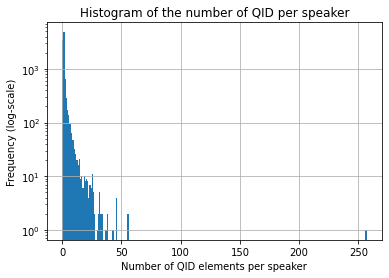

In [13]:
# Check QID list's length of every loaded quotes 
length_qids = np.zeros(len(df_quotes))
for idx, qids in enumerate(df_quotes["qids"].values):
  length_qids[idx] = len(qids)
# Plot a histogram with log-scale on Y axis
plt.hist(length_qids, bins=int(np.max(length_qids)))
plt.yscale('log')
plt.grid('on')
plt.xlabel("Number of QID elements per speaker")
plt.ylabel("Frequency (log-scale)")
plt.title("Histogram of the number of QID per speaker")
#plt.xlim(0, 30) # Uncomment for focusing on a specific region 
plt.show()

In [14]:
# Display the frequency using a dataframe instead of a histogram
val, freq = np.unique(length_qids, return_counts=True)
df_QID_freq = pd.DataFrame(data={"Nb. of QID":val, "Frequency":freq})
df_QID_freq.head(5)

,Nb. of QID,Frequency
0,0.0,3425
1,1.0,4832
2,2.0,663
3,3.0,285
4,4.0,170


#### Load the human interpretable labels

In [15]:
path_to_file = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
# Directly use the built-in pandas function as the CSV is quite small 
df_labels_wiki = pd.read_csv(path_to_file,  encoding='utf-8', compression="bz2")
df_labels_wiki.head(5)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


The function `retrieve_wikidata_properties` simply returns the wikidata properties of the given person.

In [16]:
def retrieve_wikidata_properties(person):
  # This function simply returns the wikidata properties of the given person
  return wikidata_speakers[wikidata_speakers["id"]==person]

The function `human_readable_properties` converts the QIDs into human readable format.

In [17]:
def human_readable_properties(data, property):
  list_QID = (data.iloc[0][property])
  list_values = []
  # Start by testing whether there is value
  if not(list_QID is None):
    # As there might be several values per property, we iterate on them
    for idx, QID in enumerate(list_QID):
      # Check whether the QID is corrupted, i.e. do not start by Q or less than two characters 
      if len(QID) >= 2 and QID[0] == 'Q':
        # Retrieve the Label (not description) of the QID item in the dataframe containing wikidata label
        # In df_labels_wiki, select the row that corresponds to the QID of interst 
        selector = df_labels_wiki["QID"] == QID 
        # Then extract the label of the QID/item of interest
        list_values.append(df_labels_wiki[selector].iloc[0]["Label"])
      else:
        warnings.warn("This is a corrupted QID, no value is returned!")
    return list_values
  else:
    warnings.warn("There is no value for this property!")
    return None  

## C) Data preparation

### 1. Get each speaker's vocabulary

#### I) Tokenise the sentences (turn them into single words)

* [Some interesting information on tokenization](https://towardsdatascience.com/overview-of-nlp-tokenization-algorithms-c41a7d5ec4f9)
* [Multi-Word Expression tokenizer](https://www.nltk.org/_modules/nltk/tokenize/mwe.html)

In [49]:
df_quotes["tokenized_quote"] = df_quotes.quotation.apply(word_tokenize)  # Tokenize quotes and add them in the dataframe as new column
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,tokenized_quote,sentiment
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E,"[[, D, ], espite, the, efforts, of, the, partn...","{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp..."
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E,"[[, Department, of, Homeland, Security, ], was...","{'neg': 0.184, 'neu': 0.579, 'pos': 0.237, 'co..."
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E,"[..., He, (, Madhav, ), also, disclosed, that,...","{'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'com..."
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E,"[..., [, I, ], f, it, gets, to, the, floor, ,]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E,"[[, I, met, them, ], when, they, just, turned,...","{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp..."


Issue to solve: We need to find a way to reconstruct such abbreviated words like in the cell below...

In [23]:
word_tokenize("it's, they're, can't")

['it', "'s", ',', 'they', "'re", ',', 'ca', "n't"]

Issue to solve: Handle words or letter in squared brackets, as we can see in the next cell
* Single letter likely to belong to next word
* One or more words in these brackets were not spoken by the speaker

In [50]:
df_quotes.loc[0][["quotation", "tokenized_quote"]]

quotation          [ D ] espite the efforts of the partners to cr...
tokenized_quote    [[, D, ], espite, the, efforts, of, the, partn...
Name: 0, dtype: object

#### II) Sentiment analysis

In [27]:
sia = SentimentIntensityAnalyzer()
#sia.polarity_scores("Hi, how are you?")
#sia.polarity_scores("Wow, NLTK is really powerful!")
sia.polarity_scores("You are a piece of shit!!")  # Just a test for a negative sentence. Don't take it personnally

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'compound': -0.6351, 'neg': 0.511, 'neu': 0.489, 'pos': 0.0}

In [28]:
df_quotes["sentiment"] = df_quotes.quotation.apply(sia.polarity_scores)
df_quotes.sentiment.head()

0    {'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...
1    {'neg': 0.184, 'neu': 0.579, 'pos': 0.237, 'co...
2    {'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'com...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...
Name: sentiment, dtype: object

#### III) Remove punctuation and stopwords, lowercase everything

In [51]:
#should be easy enough, don't mess it up

EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords
PUNCTUATION = set(string.punctuation)  # Punctuation

def lowercase(l):
    return [w.lower() for w in l]

def remove_stopwords(l):
    return [w for w in l if w.lower() not in EN_STOPWORDS]

def remove_punctuation(l):
    return [w for w in l if w not in PUNCTUATION]

def process_tokens(l):
    l = lowercase(l)  # Lowercase tokens
    l = remove_stopwords(l)   # Remove stopwords from tokens
    l = remove_punctuation(l)  # Remove punctuation from tokens
    return l

df_quotes["tokenized_quote"] = df_quotes.tokenized_quote.apply(process_tokens)
df_quotes[["quotation", "tokenized_quote"]].head()

,quotation,tokenized_quote
0,[ D ] espite the efforts of the partners to cr...,"[espite, efforts, partners, create, non-politi..."
1,[ Department of Homeland Security ] was livid ...,"[department, homeland, security, livid, strong..."
2,... He (Madhav) also disclosed that the illega...,"[..., madhav, also, disclosed, illegal, bribe,..."
3,"... [ I ] f it gets to the floor,","[..., f, gets, floor]"
4,[ I met them ] when they just turned 4 and 7. ...,"[met, turned, 4, 7, little, felt, like, full-b..."


#### IV) Lemmatize the words (i.e. {'eating', 'eat', 'ate'} -> "eat")
* [Source](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

In [52]:
WNL = WordNetLemmatizer()

def lem_words(l):
    return [WNL.lemmatize(w, pos='v') for w in l]  # POS = part-of-speech, used to give context to the lemmatizer ('v' -> verb)

df_quotes["tokenized_quote"] = df_quotes.tokenized_quote.apply(lem_words)  # Lemmatize tokens
df_quotes[["quotation", "tokenized_quote"]].head()

,quotation,tokenized_quote
0,[ D ] espite the efforts of the partners to cr...,"[espite, efforts, partner, create, non-politic..."
1,[ Department of Homeland Security ] was livid ...,"[department, homeland, security, livid, strong..."
2,... He (Madhav) also disclosed that the illega...,"[..., madhav, also, disclose, illegal, bribe, ..."
3,"... [ I ] f it gets to the floor,","[..., f, get, floor]"
4,[ I met them ] when they just turned 4 and 7. ...,"[meet, turn, 4, 7, little, felt, like, full-bl..."


#### V) Pool tokens by speaker

In [ ]:
# TODO

### 2. Assign an 'importance' score to each word

#### I) Cambridge dictionary CEFR score and register

In [31]:
def retrieve_CEFR_levels_registers(word):
  """ Functions that retrives the ECFR level of the given word as well as its register
      Input: 
        word - a string the word you want to inspect 
      Output: 
        levels - a numpy array containing strings, if empty no info was available
        registers - a list of strings, if empty no info was available
  """
  # Make a request to Cambridge dictionnary - simply add "word" to the url  
  url = 'https://dictionary.cambridge.org/dictionary/english/'+word
  # Websites don't like it when bots connect to them, so we have to pretend being a web browser! 
  req = ul.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  client = ul.urlopen(req)
  # Read and store data into htmldata 
  htmldata = client.read()
  client.close()

  # Create a beautiful soup element and parse it as an html file
  parsed_page = soup(htmldata, "html.parser")

  # A bit of backgrond:
  # In order to display the ECFR classification, the website uses <span> tags with a unique CSS class
  # The class is called "epp-xref dxref XX", where XX is any of the levels A1 to C2
  # Now we use 'bs4.find_all' to retrieve all span tag with the given class 
  # If none are returned, it means the level is not contained in the word 

  # Tag specific to the ECFR classification CSS class  
  class_name_level = "epp-xref dxref " 

  # The ECFR classification spans from A1 to C2, test for each case
  cases = np.array(["A1", "A2", "B1", "B2", "C1", "C2"])
  # We store the results in a bool vector from A1 to C2, corresponding to the level of the word  
  results = []
  for case in cases:
    # This checks how many times the case is present on page
    occurences = len(parsed_page.find_all("span", class_= class_name_level+case))
    # If the case is present more than 0 times, then the word can be classified in the given case 
    if occurences > 0:
      results.append(True)
    else: 
      results.append(False) 

  # Now let's retrieve the registers
  # We can apply the same strategy, the register of the word is contained in CSS class "usage dusage"

  class_name_register = "usage dusage"
  parsed_registers = parsed_page.find_all("span", class_=class_name_register)
  registers = []
  for register in parsed_registers:
    # Simply extract the information between the tags "span" with class class_name_register
    registers.append(register.string)

  return cases[results], registers

In [32]:
# Add line for the word you want to look for 
levels, reg = retrieve_CEFR_levels_registers("exhaustive")
print(levels, reg)

['C1'] []


#### II) CEFR level of sentences

Try to implement something similar to `retrieve_ECFR_levels_registers(word)` using the web site [English Profile](http://englishprofile.org/wordlists/text-inspector) for analysing a whole sentence and get the CEFR level of each word (may be better for analysing whole quotes, and does not require stemming.)

In [ ]:
# TODO Quentin, give it a try and see how far I can go 

### 3. Create a vocabulary specific to each category in interest

#### Classify speakers into categories of interest

* Each speaker can belong to multiple categories

In [ ]:
df_quotes.sample(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
6685,2020-02-09-039076,That was it. We pretty much committed to it th...,Jesse Marshall,[Q1251661],2020-02-09 03:59:27,1,"[[Jesse Marshall, 0.5131], [None, 0.4869]]",[https://calgaryherald.com/life/homes/condos/c...,E
823,2020-03-20-027710,I want you to wake up and go `Yes! This speaks...,Blair Williams,"[Q19349673, Q54850923]",2020-03-20 08:26:07,1,"[[Blair Williams, 0.8063], [None, 0.1937]]",[http://cdapress.com/news/2020/mar/20/art-spir...,E
3462,2020-02-12-044949,I'll sell to whoever suits me.,None,[],2020-02-12 19:05:24,2,"[[None, 0.802], [Peter Cairns, 0.198]]",[https://www.stuff.co.nz/waikato-times/news/ta...,E
1470,2020-03-04-050429,Scott Morrison is finally talking about an eco...,Kate Jones,"[Q20235524, Q41718769, Q56867959, Q6375568]",2020-03-04 11:22:02,3,"[[Kate Jones, 0.9298], [None, 0.0702]]",[https://www.brisbanetimes.com.au/politics/que...,E
7894,2020-01-16-016611,"Dr Obiora, upon confirmation by the Senate, re...",Muhammadu Buhari,[Q361567],2020-01-16 00:00:00,1,"[[Muhammadu Buhari, 0.8947], [None, 0.0642], [...",[https://punchng.com/buhari-appoints-kingsley-...,E
2349,2020-03-09-075838,"We've got statewide plans for quarantining, an...",Garlin Gilchrist,[Q58323075],2020-03-09 17:37:08,1,"[[Garlin Gilchrist, 0.838], [None, 0.162]]",[https://www.wsjm.com/2020/03/09/lieutenant-go...,E
7634,2020-02-29-001484,All the students came out and packed the place...,None,[],2020-02-29 03:32:52,1,"[[None, 0.9891], [Drew Martin, 0.0109]]",[http://www.bostonglobe.com/sports/high-school...,E
6445,2020-01-04-027424,People are watching and they understand. Despi...,Yogi Adityanath,[Q4683097],2020-01-04 14:10:21,10,"[[Yogi Adityanath, 0.6763], [None, 0.2946], [P...",[https://www.business-standard.com/article/pti...,E
1619,2020-01-26-038896,That's not OK because I'm leaning towards Klob...,None,[],2020-01-26 21:28:33,2,"[[None, 0.8026], [Amy Klobuchar, 0.0893], [Eli...",[http://chron.com/news/article/In-Iowa-a-long-...,E
1223,2020-01-29-062975,Many make the link today between their experie...,Peter Maurer,"[Q117796, Q42426597]",2020-01-29 09:04:36,5,"[[Peter Maurer, 0.8787], [None, 0.1213]]",[http://whbl.com/news/articles/2020/jan/29/hun...,E


In [33]:
# A small scale test on quote 6685
quote_nb = 6685
print("The quote is: \n"+df_quotes.loc[quote_nb].quotation)

The quote is: 
That was it. We pretty much committed to it the next weekend,


In [40]:
# Extract the word 'commited' and get the CEFR (totally empirical, we are waiting on a better tokenizer)
levels, reg = retrieve_CEFR_levels_registers(df_quotes.loc[quote_nb].quotation.split()[6])
print(levels, reg)

['C2'] []


Now get some info about the speaker. Use the data provided in the .parquet file.

In [35]:
# Find the QID of the speaker 
QID = df_quotes.loc[quote_nb].qids[0]
# Display the known properties for the persone given
df_properties = retrieve_wikidata_properties(QID)
df_properties

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7965801,None,[+1980-10-18T00:00:00Z],[Q30],[Q6581097],1323455881,None,None,[Q4144610],None,None,Q1251661,Jesse Marshall,None,item,None


In [36]:
# Retrieve the occupation in human readable format 
human_readable_properties(df_properties, "occupation")

['alpine skier']

In [37]:
# Retrieve the nationality in human readable format 
human_readable_properties(df_properties, "nationality")

['United States of America']

In [38]:
# Retrieve the candidacy in human readable format 
human_readable_properties(df_properties, "candidacy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: There is no value for this property!


## D) Data analysis

For now, this section only contains code that we will eventually use later.

##### nltk.collocations without POS tags

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

PUNCTUATION = set(string.punctuation)  # Punctuation
EN_STOPWORDS = set(stopwords.words("english"))  # English stopwords

def format_quote_for_collocation_finder(l):
    newL = [w.lower() for w in l]  # lowercase everything
    newL = ["<P>" if w in PUNCTUATION else w for w in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = ["<S>" if w in EN_STOPWORDS else w for w in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, "<B>")  # Add begin tag
    newL.append("<E>")  # Add end tag
    return newL

marked_quotes = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder)
all_marked_quotes = [token for l in marked_quotes for token in l]

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_marked_quotes)

frequency = 4  # Minimum number of occurences of the bigram
finder.apply_freq_filter(frequency)

finder.nbest(bigram_measures.pmi, 15)  # n most collocated words
#finder.score_ngrams(bigram_measures.pmi)  # Scores

##### nltk.collocations with POS tags

In [ ]:
nltk.download('averaged_perceptron_tagger')

def format_quote_for_collocation_finder_tagged(l):
    newL = nltk.pos_tag(l)
    newL = [(w.lower(), tag) for (w, tag) in newL]  # lowercase everything
    newL = [("<P>", "TAG-P") if w in PUNCTUATION else (w, tag) for (w, tag) in newL]  # We don't remove punctuation yet, as they act as separators between words, which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a punctuation tag
    newL = [("<S>", "TAG-S") if w in EN_STOPWORDS else (w, tag) for (w, tag) in newL]  # We don't remove the stopwords yet, as they act as separators between non-stopwords which we need to construct meaningful bigrams for collocation finding. Instead, we replace them by a stopword tag
    # We add starting and ending tags to mark end of quotes and avoid constructing bigrams of the end word of a quote and the start word of the next one which is unrelated.
    newL.insert(0, ("<B>", "TAG-B"))  # Add begin tag with random POS tag
    newL.append(("<E>", "TAG-E"))  # Add end tag with random POS tag
    return newL

marked_quotes_tagged = quotes_selected_speakers.tokenized_quote.apply(format_quote_for_collocation_finder_tagged)
all_marked_quotes_tagged = [token for l in marked_quotes_tagged for token in l]

In [ ]:
finder_tagged = BigramCollocationFinder.from_words(all_marked_quotes_tagged)
frequency_tagged = 3
finder_tagged.apply_freq_filter(frequency_tagged)
finder_tagged.nbest(bigram_measures.pmi, 15)  # n most collocated words

##### Named entity recognition

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

ner_quotes = quotes_selected_speakers.tokenized_quote.apply(nltk.pos_tag)
ner_quotes = ner_quotes.apply(nltk.ne_chunk)
ner_quotes.head()

In [ ]:
print(ner_quotes[86])